# Notebook 5/6: Implementing Complex non-linear model: XGBoost

In [4]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold, RandomizedSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

from utils.Baseline_training_utils import *
from utils.Model_utils import *
import os
from xgboost import XGBRegressor
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Loading data and applying the prediction of the binary posture classifier for the test data

In [20]:
#Loading datasets with all sessions and normalized features
X_train = pd.read_csv('Cleaned_Datasets/Train_final.csv') 
X_test = pd.read_csv('Cleaned_Datasets/Test_final.csv')

# dropping inactive sessions on the train 
X_train = X_train[X_train["Session"] != 0]

# dropping rows with predicted standing posture using the binary classifier
sensor_names = [f"Sensor {i}" for i in [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12]]
binary_posture_classifier = joblib.load('runs/Seated_Classifier.joblib')
X_test['Seated'] = binary_posture_classifier.predict(X_test[sensor_names])
X_test = X_test[X_test['Seated'] == 1]

# Defining target variables
y_train_thigh = X_train[['thigh_flux']] # Target variables
y_train_back = X_train[['back_flux']] 

y_test_thigh = X_test[['thigh_flux']] # Target variables
y_test_back = X_test[['back_flux']]

# Creating minimal dataset to be completed with selected features only
cols_to_keep = ['participant_id', 'Time','Sensor 0', 'Sensor 1', 'Sensor 2', 
                'Sensor 3', 'Sensor 4', 'Sensor 5', 'Sensor 6', 'Sensor 7', 
                'Sensor 9', 'Sensor 10', 'Sensor 11', 'Sensor 12', 'chair_back_flux', 'chair_thigh_flux']

# Creating historical datasets without posture and target variables
X_train_historical = X_train.copy().drop(columns=['Session', 'thigh_flux', 'back_flux', 'room_temp_C'])
X_test_historical = X_test.copy().drop(columns=['Seated', 'Session', 'thigh_flux', 'back_flux', 'room_temp_C'])

X_train = X_train.loc[:, cols_to_keep]
X_test = X_test.loc[:, cols_to_keep]

## 1. Implementing XGBoost to try and catch data's non-linearities

In [21]:
# Adding personnal features
X_train_perso = add_personal_characteristics(X_train)
X_test_perso = add_personal_characteristics(X_test)

# Mapping F to 1 and M ton 0 
X_train_perso["Sex"] = X_train_perso["Sex"].map({"F": 0, "M": 1})
X_test_perso["Sex"] = X_test_perso["Sex"].map({"F": 0, "M": 1})

In [42]:
xgb_model = Pipeline([
    (
        "xgb",
        XGBRegressor(
            objective="reg:squarederror",
            n_estimators=300,
            random_state=0,
            tree_method="hist",   # stable & rapide
            verbosity=0
        )
    )
])

xgb_params = {
    "xgb__n_estimators": [600, 1000, 1500],   # 4
    "xgb__learning_rate": [0.05, 0.1, 0.2],   # 4
    "xgb__max_depth": [6, 8, 10],               # 4
    "xgb__min_child_weight": [1, 3],                # 2
}


In [ ]:
bundle_xgb = cv_select_and_refit_on_full_train(
    X_train=X_train_perso,
    y_train=y_train_thigh,              # DataFrame (n,1)
    base_estimator=xgb_model,
    param_grid=xgb_params,
    model_name="XGBoost",
    model_title="XGB_Thigh_perso",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    drop_non_numeric=True,
    return_oof=True
)


[XGBoost] Launching...
[XGBoost] #param combinations: 54 | outer folds: 5
  Combo 1/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 600}
    MAE mean/std: 15.3622 ± 2.0308 | MSE mean/std: 384.1736 ± 107.7064
  Combo 2/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 1000}
    MAE mean/std: 15.4796 ± 1.9490 | MSE mean/std: 389.3571 ± 105.5568
  Combo 3/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 1500}
    MAE mean/std: 15.5816 ± 1.9558 | MSE mean/std: 395.2313 ± 108.2038
  Combo 4/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 600}
    MAE mean/std: 15.6372 ± 1.9451 | MSE mean/std: 400.7324 ± 108.0035
  Combo 5/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 1000}
    MAE mean/std: 15.7547 ± 2.0646 | MSE mean/st

/Users/zac/Desktop/ICE-human-heatflux-project/utils/personnal_characteristics_utils.py:628: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(parts, ignore_index=True)


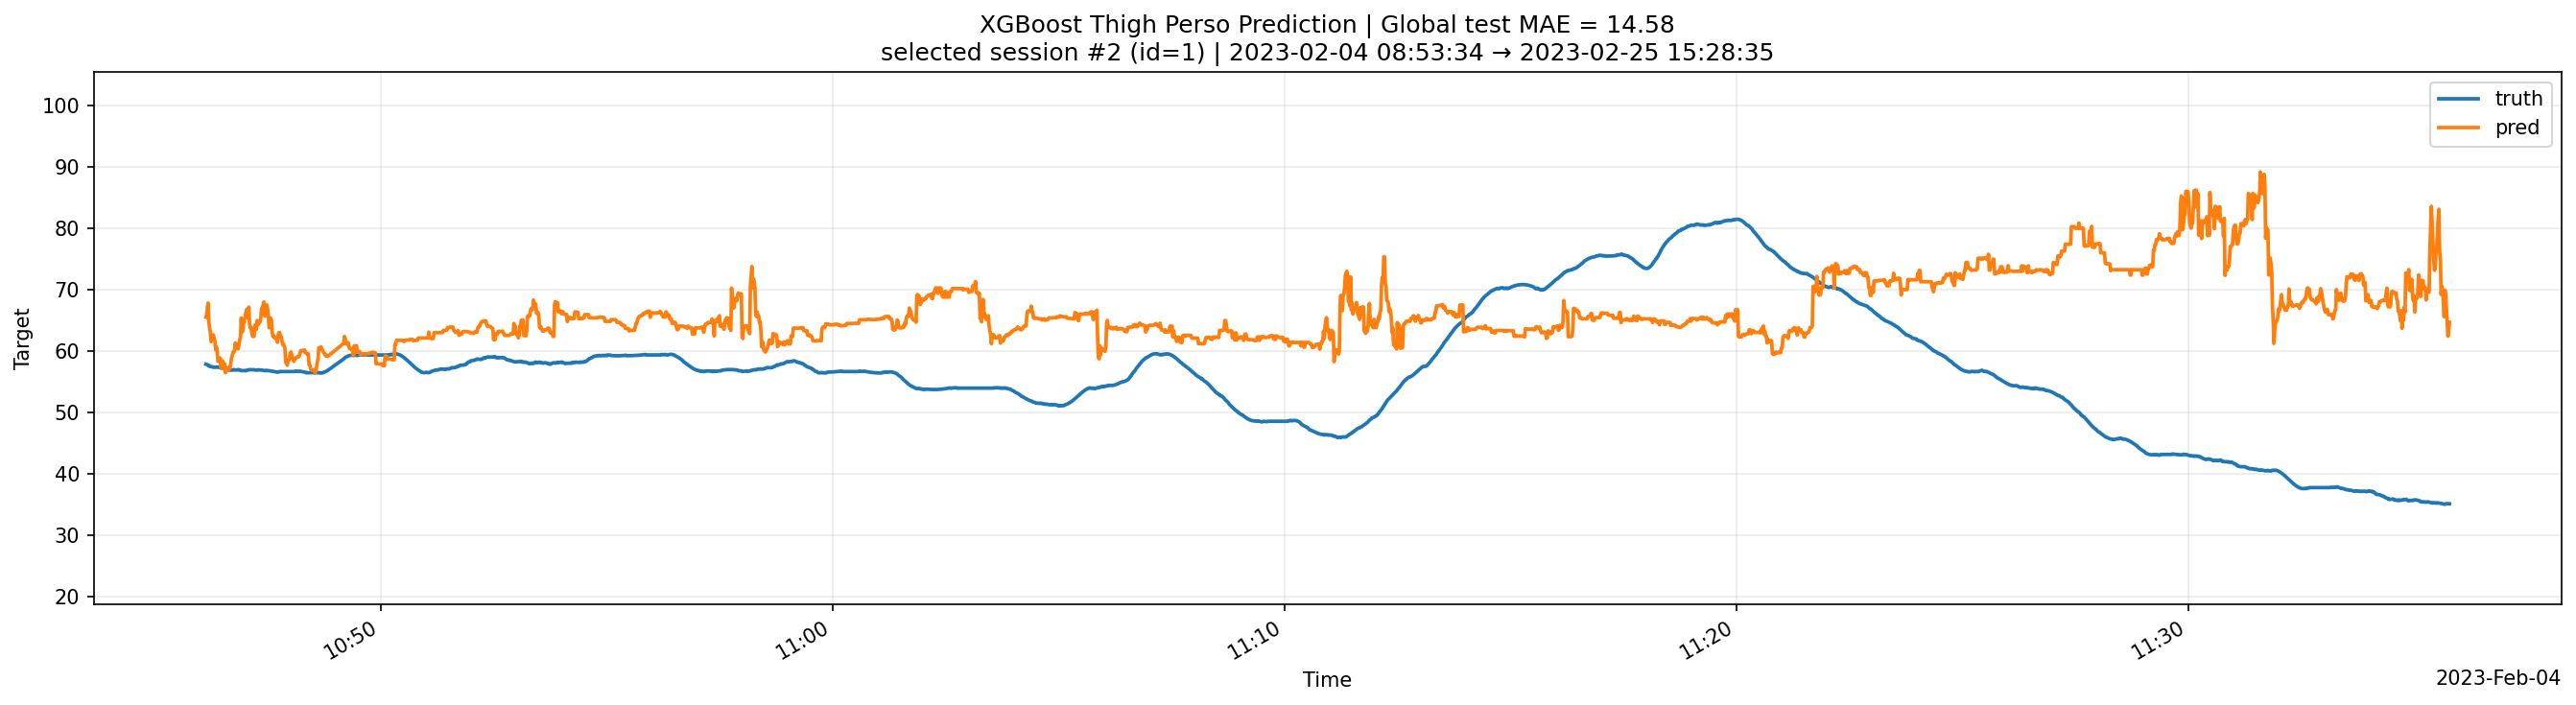

In [ ]:
bundle_xgb_thigh_perso = joblib.load('runs/XGB_Thigh_perso2.joblib')

pred_xgb = predict_and_plot(bundle_xgb_thigh_perso['model'], 
                            X_test_perso, 
                            y_test_thigh, mode="selected", 
                            participant_id='F7', 
                            session_number=2, 
                            title="XGBoost Thigh Perso Prediction",
                            gap_minutes=5)

In [45]:
bundle_xgb = cv_select_and_refit_on_full_train(
    X_train=X_train_perso,
    y_train=y_train_back,              # DataFrame (n,1)
    base_estimator=xgb_model,
    param_grid=xgb_params,
    model_name="XGBoost",
    model_title="XGB_Back_perso2",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    drop_non_numeric=True,
    return_oof=True,
)


[XGBoost] Launching...
[XGBoost] #param combinations: 54 | outer folds: 5
  Combo 1/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 600}
    MAE mean/std: 15.6819 ± 2.5560 | MSE mean/std: 462.1531 ± 187.4483
  Combo 2/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 1000}
    MAE mean/std: 16.2220 ± 2.4547 | MSE mean/std: 488.4561 ± 184.7487
  Combo 3/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 1500}
    MAE mean/std: 16.5850 ± 2.2560 | MSE mean/std: 503.1911 ± 176.8240
  Combo 4/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 600}
    MAE mean/std: 15.7609 ± 2.4889 | MSE mean/std: 462.2515 ± 190.0938
  Combo 5/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 1000}
    MAE mean/std: 16.1053 ± 2.1979 | MSE mean/st

/Users/zac/Desktop/ICE-human-heatflux-project/utils/personnal_characteristics_utils.py:628: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(parts, ignore_index=True)


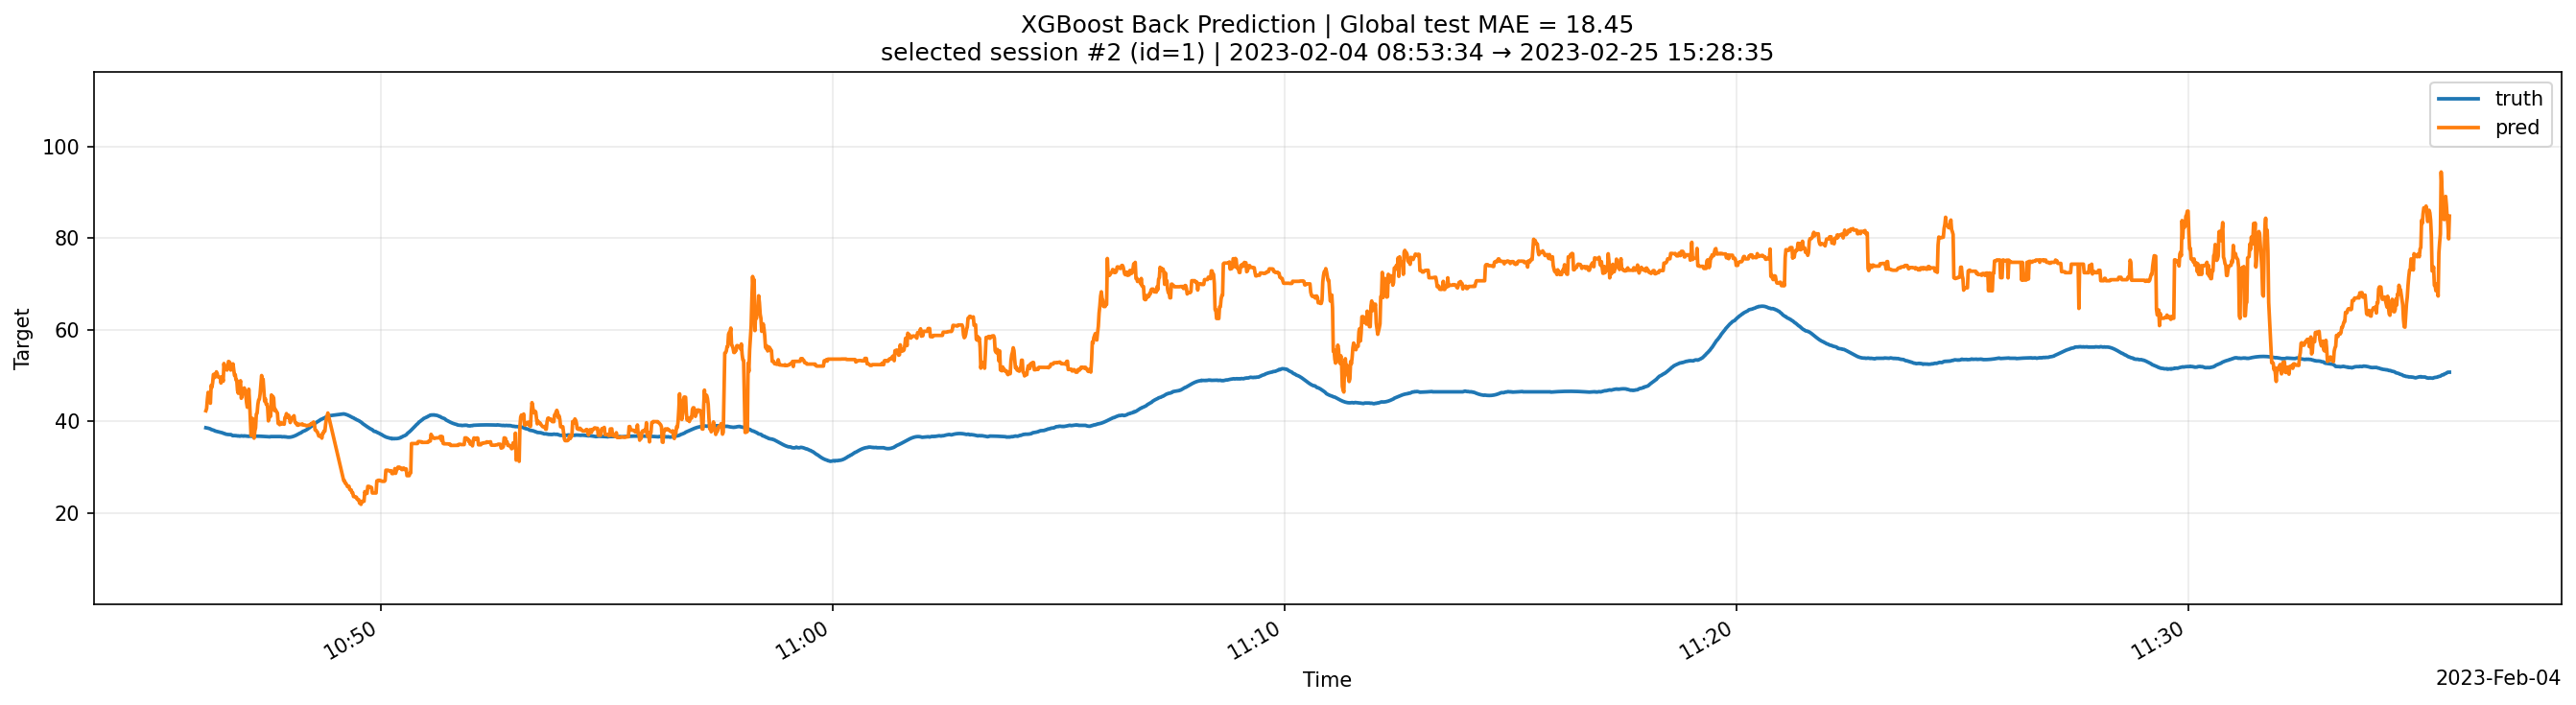

In [60]:
bundle_xgb_back_perso = joblib.load('runs/XGB_Back_perso2.joblib')

pred_xgb = predict_and_plot(bundle_xgb_back_perso['model'], 
                            X_test_perso, 
                            y_test_back, mode="selected", 
                            participant_id='F7', 
                            session_number=2, 
                            title="XGBoost Back Prediction",
                            gap_minutes=5
                            )

### 1.2 Without personnal features

In [47]:
bundle_xgb = cv_select_and_refit_on_full_train(
    X_train=X_train,
    y_train=y_train_thigh,              # DataFrame (n,1)
    base_estimator=xgb_model,
    param_grid=xgb_params,
    model_name="XGBoost",
    model_title="XGB_Thigh_baseline",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    drop_non_numeric=True,
    return_oof=True
)


[XGBoost] Launching...
[XGBoost] #param combinations: 54 | outer folds: 5
  Combo 1/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 600}
    MAE mean/std: 14.7235 ± 1.9416 | MSE mean/std: 360.2539 ± 103.0069
  Combo 2/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 1000}
    MAE mean/std: 14.8398 ± 1.8882 | MSE mean/std: 366.2500 ± 102.1100
  Combo 3/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 1500}
    MAE mean/std: 14.8960 ± 1.9086 | MSE mean/std: 368.7625 ± 103.2187
  Combo 4/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 600}
    MAE mean/std: 14.6958 ± 1.8112 | MSE mean/std: 361.2470 ± 95.7267
  Combo 5/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 1000}
    MAE mean/std: 14.8601 ± 1.7558 | MSE mean/std

/Users/zac/Desktop/ICE-human-heatflux-project/utils/personnal_characteristics_utils.py:628: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(parts, ignore_index=True)


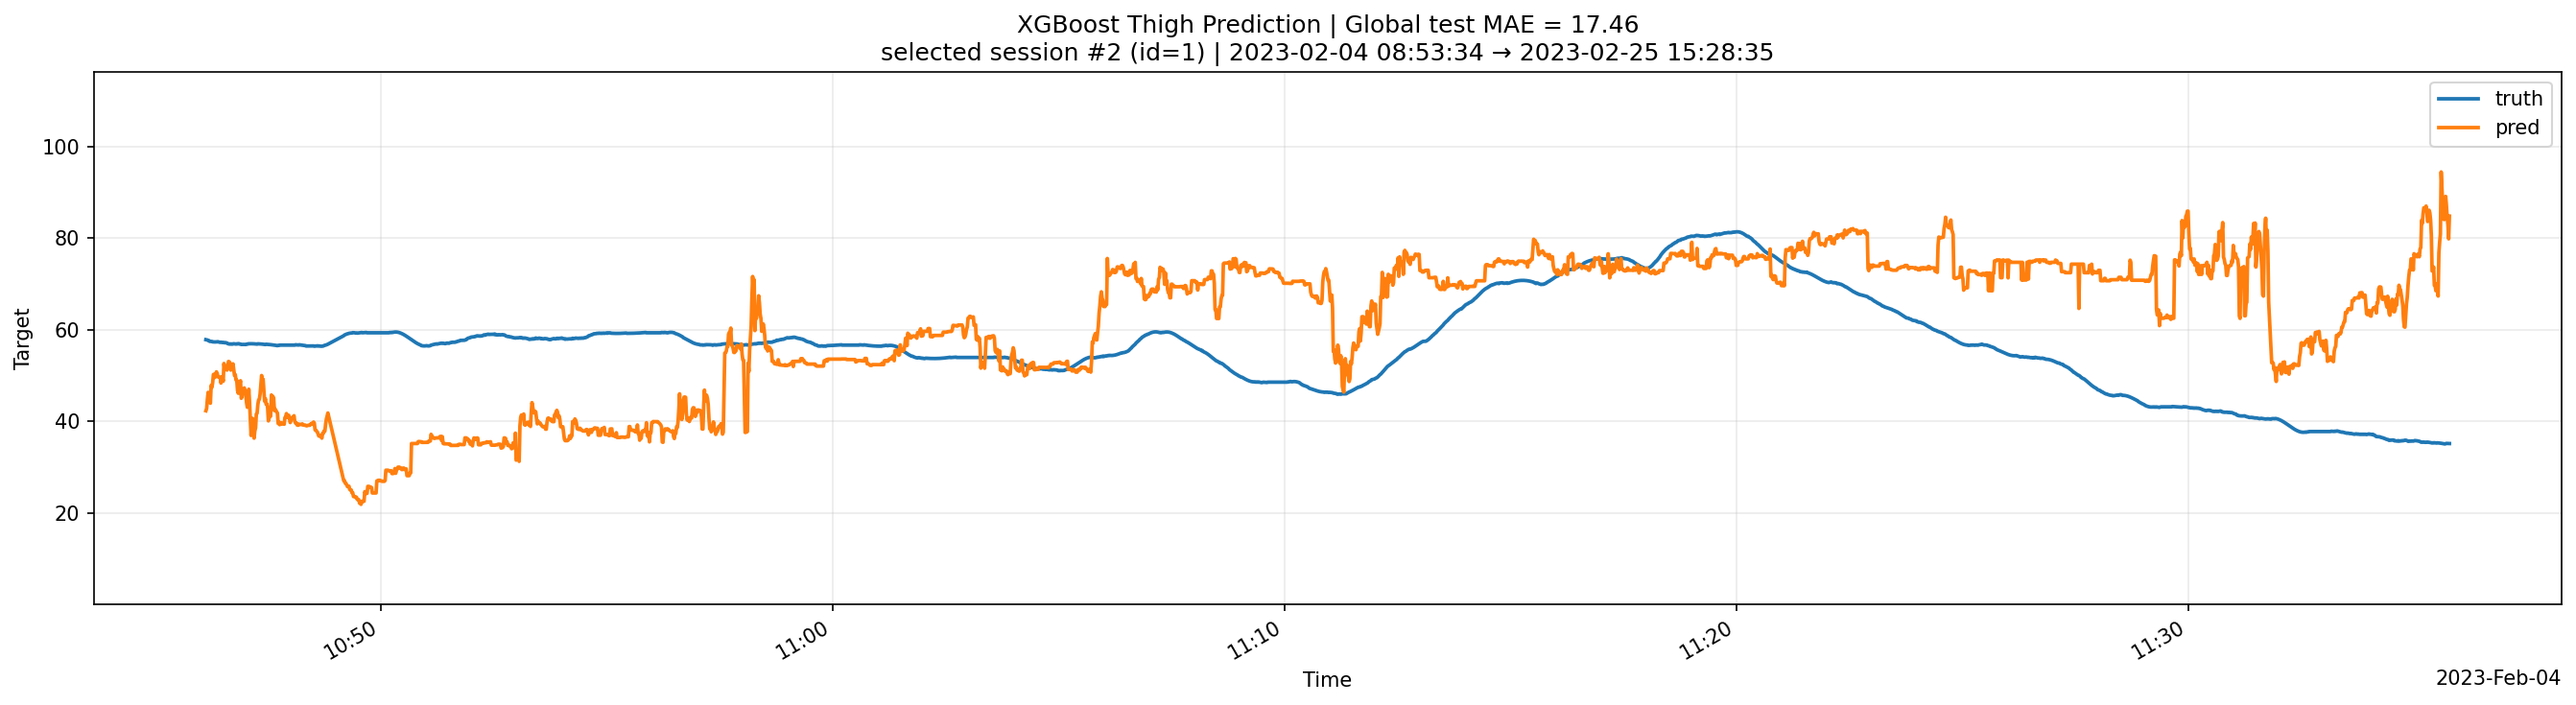

In [61]:
bundle_xgb_thigh_baseline = joblib.load('runs/XGB_Thigh_baseline.joblib')

pred_xgb = predict_and_plot(bundle_xgb_back_perso['model'], 
                            X_test_perso, 
                            y_test_thigh, mode="selected", 
                            participant_id='F7', 
                            session_number=2, 
                            title="XGBoost Thigh Prediction",
                            gap_minutes=5)

In [49]:
bundle_xgb = cv_select_and_refit_on_full_train(
    X_train=X_train,
    y_train=y_train_back,              # DataFrame (n,1)
    base_estimator=xgb_model,
    param_grid=xgb_params,
    model_name="XGBoost",
    model_title="XGB_Back_baseline",
    participant_col="participant_id",
    time_col="Time",
    n_outer_splits=5,
    drop_non_numeric=True,
    return_oof=True
)


[XGBoost] Launching...
[XGBoost] #param combinations: 54 | outer folds: 5
  Combo 1/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 600}
    MAE mean/std: 15.4497 ± 2.4651 | MSE mean/std: 451.0006 ± 166.6127
  Combo 2/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 1000}
    MAE mean/std: 15.6427 ± 2.4696 | MSE mean/std: 460.7194 ± 170.0997
  Combo 3/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 1500}
    MAE mean/std: 15.7207 ± 2.4495 | MSE mean/std: 462.9073 ± 169.3988
  Combo 4/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 600}
    MAE mean/std: 15.1503 ± 2.1766 | MSE mean/std: 440.3732 ± 161.7739
  Combo 5/54: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 1000}
    MAE mean/std: 15.3809 ± 2.1367 | MSE mean/st

/Users/zac/Desktop/ICE-human-heatflux-project/utils/personnal_characteristics_utils.py:628: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat(parts, ignore_index=True)


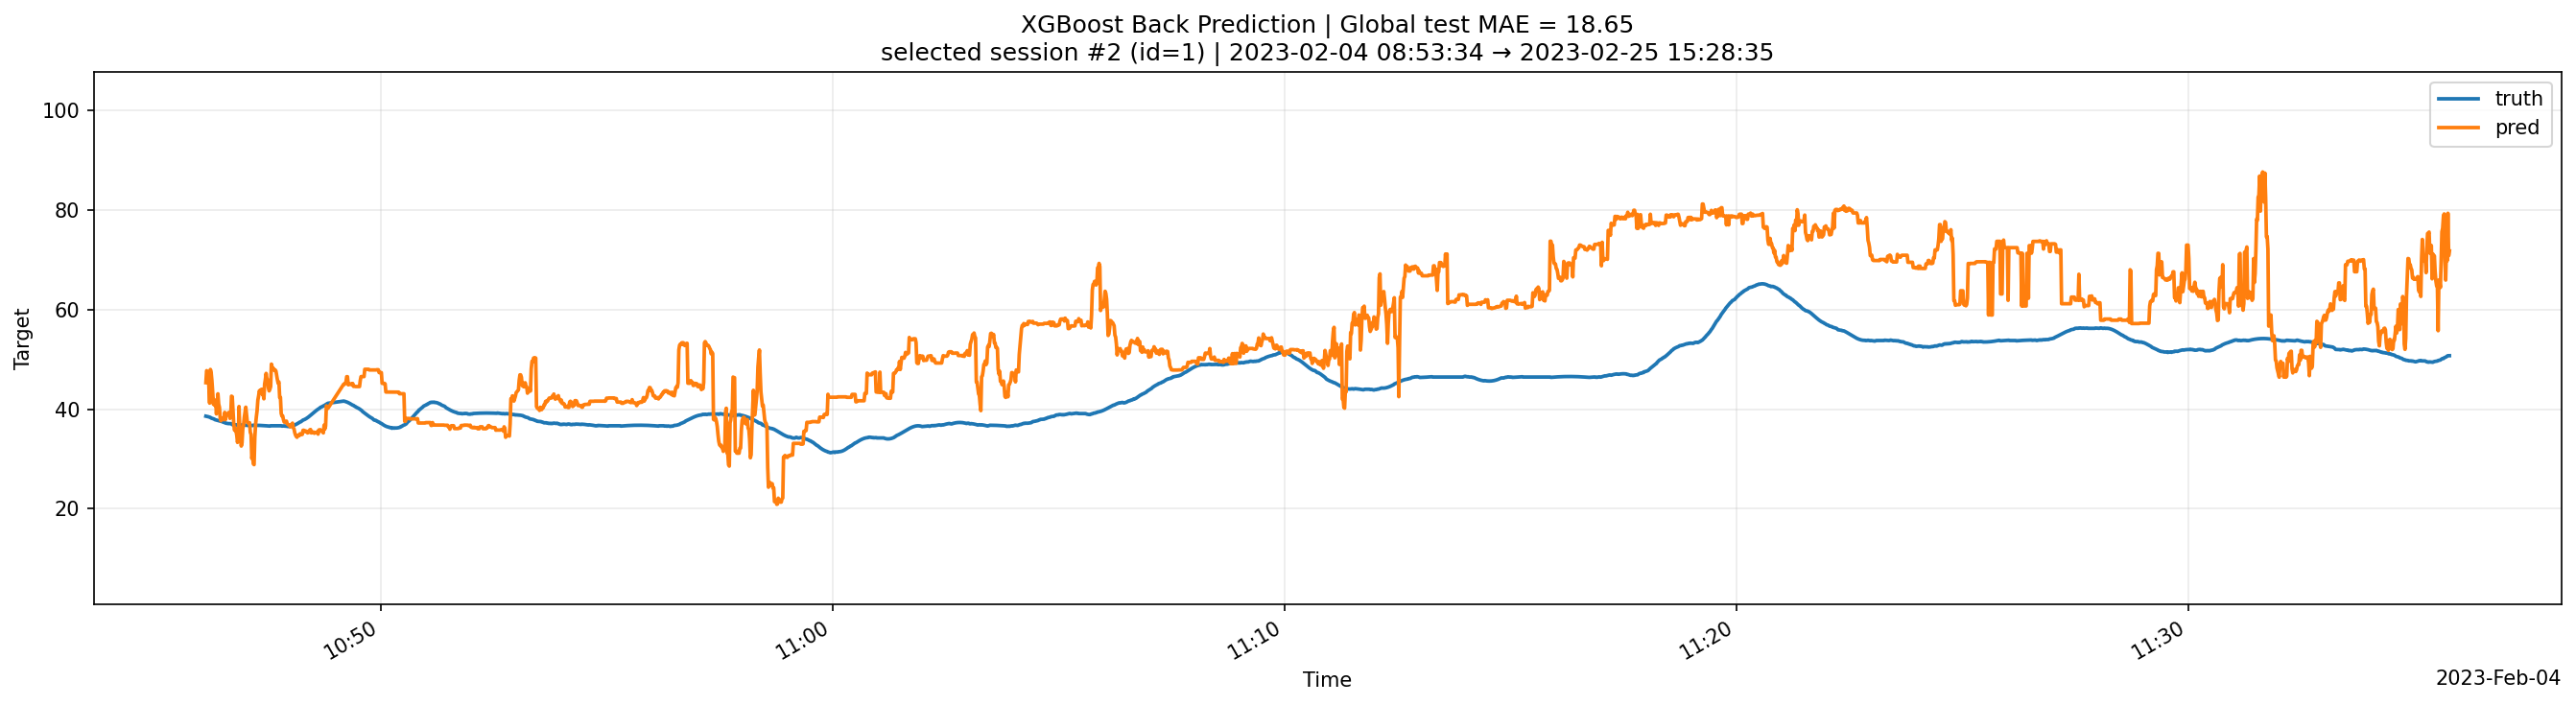

In [62]:
bundle_xgb_back_baseline = joblib.load('runs/XGB_Back_baseline.joblib')

pred_xgb = predict_and_plot(bundle_xgb_back_baseline['model'], 
                            X_test, 
                            y_test_back, mode="selected", 
                            participant_id='F7', 
                            session_number=2, 
                            title="XGBoost Back Prediction",
                            gap_minutes=5)